### Consensus model using following algorithm

Online aggregation method for bounding box class labels

1. Collect bounding box labels with associated class and labeler
2. For each image and class, maintain an array of values from [0-1] which has the same dimensions and the original image
3. For each bounding box label, iterate over the corresponding values captured in the array and update the probabilities in the following manner:
    a. Assume independence between current values and new label
    b. Use the labellers ‘class expertise rating’ [0,1]to Calculate the likelihood of the current label AND the new label to be incorrect
    c. Update the pixel with the new confidence level
4. Continue until confidence reaches certain threshold
5. Update the values for expertise based on number correct vs number missed (MLE of observer error rates using EM algorithm 1978)


In [141]:
# imports

from PIL import Image
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.special import beta

#### Define Classes to Add Dummy Data

In [132]:
class Labeler():

    def __init__(self, id:int, initial_accuracy: dict[list[float]]):
        self.id = id
        self.accuracy = initial_accuracy

class Label():

    def __init__(self, id:int, label_class:str, labeler: Labeler, coordinates: list[int]):
        self.id = id
        self.label_class = label_class
        self.labeler = labeler
        self.coordinates = coordinates # Top Left x, TL y, Bottom Right x, BR y


#### Create Dummy Data

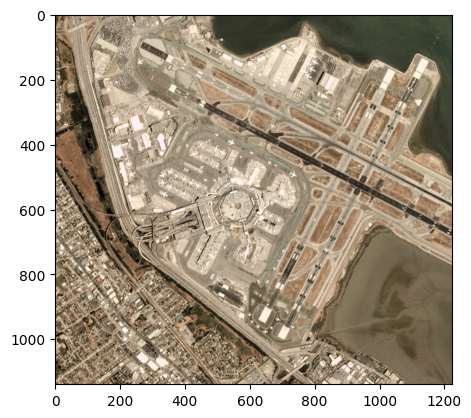

In [163]:
num_labelers = 10
initial_accuracy = {"airplane": [1.5,1]} # only one class for demo, alpha = beta = 1
labelers = [Labeler(i, initial_accuracy=initial_accuracy.copy()) for i in range(num_labelers)]

image = np.asarray(Image.open("airport.png"))

plt.imshow(image)


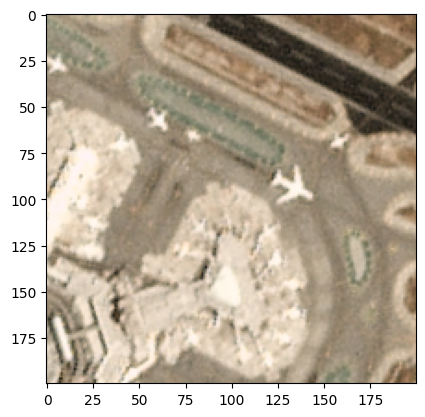

In [164]:
image = np.asarray(Image.open("airport.png").crop((600,400,800,600)))
plt.imshow(image)

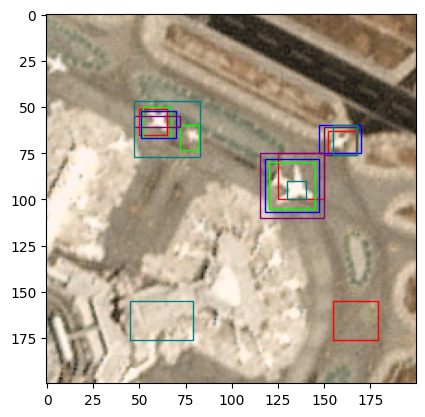

In [216]:
# add labels
labels:Label = []
#---labeller 1
labels.append(Label(0, "airplane", labelers[0], [125,75,150,100]))
labels.append(Label(1, "airplane", labelers[0], [50,51,65,65]))
labels.append(Label(2, "airplane", labelers[0], [152,63,167,75]))
labels.append(Label(3, "airplane", labelers[0], [155,155,179,176]))
#---labeller 2
labels.append(Label(4, "airplane", labelers[1], [120,80,145,105]))
labels.append(Label(5, "airplane", labelers[1], [52,50,67,67]))
labels.append(Label(6, "airplane", labelers[1], [150,61,168,76]))
labels.append(Label(7, "airplane", labelers[1], [72,60,82,73]))
#---labeller 3
labels.append(Label(8, "airplane", labelers[2], [118,78,147,107]))
labels.append(Label(9, "airplane", labelers[2], [51,52,70,67]))
labels.append(Label(10, "airplane", labelers[2], [147,60,170,75]))
#---labeller 4
labels.append(Label(11, "airplane", labelers[3], [115,75,150,110]))
labels.append(Label(12, "airplane", labelers[3], [47,55,72,61]))
labels.append(Label(13, "airplane", labelers[3], [150,61,168,76]))
#--- labeller 5
labels.append(Label(14, "airplane", labelers[4], [130,90,140,100]))
labels.append(Label(15, "airplane", labelers[4], [47,47,83,77]))
labels.append(Label(16, "airplane", labelers[4], [155,60,168,76]))
labels.append(Label(17, "airplane", labelers[4], [45,155,79,176]))



# prepate bounding boxes to be added to image
bounding_boxes = []
# for identifying labeler responsible for label
colors = [[1,0,0],
          [0,1,0],
          [0,0,1],
          [0.5,0,0.5],
          [0,0.5,0.5]]
fig, ax = plt.subplots()
ax.imshow(image)

for label in labels:
    bounding_boxes.append(patches.Rectangle(label.coordinates[0:2], label.coordinates[2]-label.coordinates[0], label.coordinates[3]-label.coordinates[1], linewidth=1, edgecolor=colors[label.labeler.id], facecolor='none'))

for bounding_box in bounding_boxes:
    ax.add_patch(bounding_box)

plt.show()


#### Generate Likelihoods of a pixel being correctly labeled

In [282]:
class ImageClassMeasure:
    # contains the values necessary to calculate the probability for each pixel to be a given label
    def __init__(self, label:str, threshold:float = 0.6):
        self.likelihoods = [[0.5] * len(image[0]) for _ in range(len(image))]
        self.confidence = [[0.0] * len(image[0]) for _ in range(len(image))]
        self.helper_values = [[[0.5,0.5] for _ in range(len(image[0]))] for _ in range(len(image))] # running total for P(w_i | L = 0) & P(w_i | L = 1)
        self.label_value = [[0.0] * len(image[0]) for _ in range(len(image))]
        self.label = label
        self.threshold = threshold

def update_label_likelihood(values: ImageClassMeasure, labels:list[Label]):
    # modifies the probabilities of each pixel being in the class based on a new set of labels made by the same labeler
    # can be ported to GPU if performance requires

    a = labels[0].labeler.accuracy.get(values.label)[0]
    b = labels[0].labeler.accuracy.get(values.label)[1]

    for row in range(len(values.likelihoods)):
        for col in range(len(values.likelihoods[0])):
            class_prediction = 0
            for label in labels:
                if (col >= label.coordinates[0] and col <= label.coordinates[2] and row >= label.coordinates[1] and row <= label.coordinates[3]):
                    class_prediction = 1
            values.helper_values[row][col][0] *= beta(1-class_prediction + a, class_prediction + b)
            values.helper_values[row][col][1] *= beta(class_prediction + a, 1-class_prediction + b)
            values.likelihoods[row][col] = values.helper_values[row][col][1] / (values.helper_values[row][col][1] + values.helper_values[row][col][0])

    
def update_label_confidence(values: ImageClassMeasure):
    for row in range(len(values.likelihoods)):
        for col in range(len(values.likelihoods[0])):
            prediction = 1 if values.likelihoods[row][col] > values.threshold else 0
            values.confidence[row][col] = abs(values.likelihoods[row][col] - 1 + prediction)



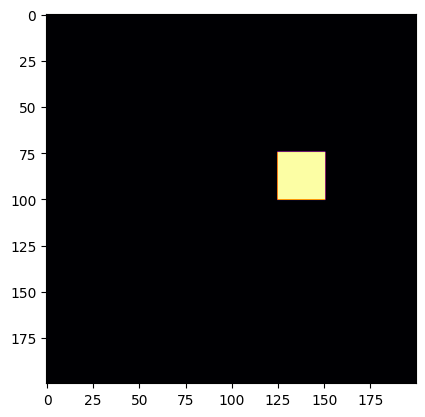

In [283]:
icm = ImageClassMeasure("airplane")

update_label_likelihood(icm, [labels[0]])
update_label_confidence(icm)
plt.imshow(icm.likelihoods, cmap='inferno')

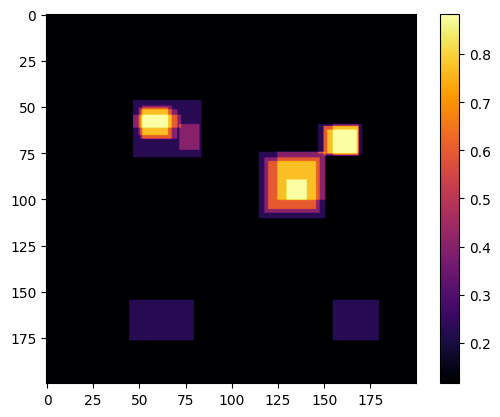

In [284]:
icm = ImageClassMeasure("airplane")
label_groups = [[labels[0],
                labels[1],
                labels[2],
                labels[3]],
                [labels[4],
                labels[5],
                labels[6],
                labels[7]],
                [labels[8],
                labels[9],
                labels[10]],
                [labels[11],
                labels[12],
                labels[13]],
                [labels[14],
                labels[15],
                labels[16],
                labels[17]],]
for group in label_groups:
    update_label_likelihood(icm, group)

update_label_confidence(icm)
plt.imshow(icm.likelihoods, cmap='inferno')
plt.colorbar()


### Obtain Predicitons

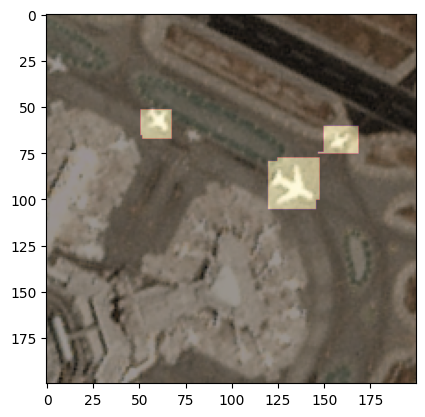

In [285]:
prediction = [[0] * len(image[0]) for _ in range(len(image))]

for row in range(len(icm.likelihoods)):
        for col in range(len(icm.likelihoods[0])):
            prediction[row][col] = 1 if icm.likelihoods[row][col] > icm.threshold else 0
plt.imshow(image)
plt.imshow(prediction, alpha=0.4, cmap='magma')

Text(0.5, 1.0, 'confidence in prediction')

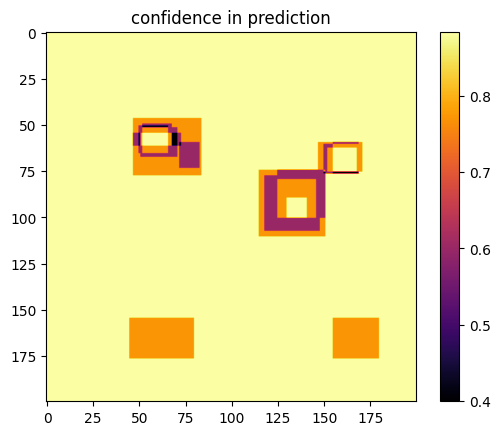

In [286]:
plt.imshow(icm.confidence, cmap='inferno')
plt.colorbar()
plt.title("confidence in prediction")